#### Preprocessing Charging Sessions Dataset

First, we import important libraries needed for the following tasks.

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast

We import the necessary dataset (charging sessions of EVs) with the data of charging garages in Los Angeles.

In [85]:
data_raw = pd.read_csv("data/charging_sessions.csv")

Getting a first sight of the data by displaying the first 5 observations.

In [86]:
data_raw.head(5)

,Unnamed: 0,id,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,sessionID,siteID,spaceID,stationID,timezone,userID,userInputs
0,0,5e23b149f9af8b5fe4b973cf,2020-01-02 13:08:54+00:00,2020-01-02 19:11:15+00:00,2020-01-02 17:31:35+00:00,25.016,1_1_179_810_2020-01-02 13:08:53.870034,1,AG-3F30,1-1-179-810,America/Los_Angeles,194.0,"[{'WhPerMile': 250, 'kWhRequested': 25.0, 'mil..."
1,1,5e23b149f9af8b5fe4b973d0,2020-01-02 13:36:50+00:00,2020-01-02 22:38:21+00:00,2020-01-02 20:18:05+00:00,33.097,1_1_193_825_2020-01-02 13:36:49.599853,1,AG-1F01,1-1-193-825,America/Los_Angeles,4275.0,"[{'WhPerMile': 280, 'kWhRequested': 70.0, 'mil..."
2,2,5e23b149f9af8b5fe4b973d1,2020-01-02 13:56:35+00:00,2020-01-03 00:39:22+00:00,2020-01-02 16:35:06+00:00,6.521,1_1_193_829_2020-01-02 13:56:35.214993,1,AG-1F03,1-1-193-829,America/Los_Angeles,344.0,"[{'WhPerMile': 400, 'kWhRequested': 8.0, 'mile..."
3,3,5e23b149f9af8b5fe4b973d2,2020-01-02 13:59:58+00:00,2020-01-02 16:38:39+00:00,2020-01-02 15:18:45+00:00,2.355,1_1_193_820_2020-01-02 13:59:58.309319,1,AG-1F04,1-1-193-820,America/Los_Angeles,1117.0,"[{'WhPerMile': 400, 'kWhRequested': 8.0, 'mile..."
4,4,5e23b149f9af8b5fe4b973d3,2020-01-02 14:00:01+00:00,2020-01-02 22:08:40+00:00,2020-01-02 18:17:30+00:00,13.375,1_1_193_819_2020-01-02 14:00:00.779967,1,AG-1F06,1-1-193-819,America/Los_Angeles,334.0,"[{'WhPerMile': 400, 'kWhRequested': 16.0, 'mil..."


In [87]:
num_rows, num_columns = data_raw.shape
print(f"rows: {num_rows}, columns: {num_columns}")

rows: 66450, columns: 13


The data in the dataset contains 66.450 observation over 13 different variables. Next, we drop duplicates and have closer look at the different datatypes.

In [88]:
columns = [
    'connectionTime', 'disconnectTime', 'doneChargingTime', 'kWhDelivered',
    'sessionID', 'siteID', 'spaceID', 'stationID', 'timezone', 'userID', 'userInputs'
]
data_unique = data_raw.drop_duplicates(subset=columns)

In [89]:
dtypes_data = data_unique.dtypes.reset_index()
dtypes_data.columns = ['Row', 'Datetype']
print(dtypes_data)

                 Row Datetype
0         Unnamed: 0    int64
1                 id   object
2     connectionTime   object
3     disconnectTime   object
4   doneChargingTime   object
5       kWhDelivered  float64
6          sessionID   object
7             siteID    int64
8            spaceID   object
9          stationID   object
10          timezone   object
11            userID  float64
12        userInputs   object


We convert all the data into corresponding data types so that we can use them in the further analysis. 
The time-related data is given in the UTC time zone, but the garages are in Los Angeles. In order to obtain accurate information about the timestamps, the data must therefore be converted to the corresponding time zone (LosAngeles).  

In [90]:
data_unique['id'] = data_unique['id'].astype("string")
data_unique['connectionTime'] = pd.to_datetime(data_unique['connectionTime'], utc=True).dt.tz_convert('America/Los_Angeles').dt.tz_localize(None)
data_unique['disconnectTime'] = pd.to_datetime(data_unique['disconnectTime'], utc=True).dt.tz_convert('America/Los_Angeles').dt.tz_localize(None)
data_unique['doneChargingTime'] = pd.to_datetime(data_unique['doneChargingTime'], utc=True).dt.tz_convert('America/Los_Angeles').dt.tz_localize(None)
data_unique['sessionID'] = data_unique['sessionID'].astype("string")
data_unique['siteID'] = data_unique['siteID'].astype("int")
data_unique['spaceID'] = data_unique['spaceID'].astype("string")
data_unique['stationID'] = data_unique['stationID'].astype("string")
data_unique['timezone'] = data_unique['timezone'].astype("string")
data_unique['userID'] = data_unique['userID'].astype("string")
data_unique['sessionID'] = data_unique['sessionID'].astype("string")
data_unique['userInputs'] = data_unique['userInputs'].apply(lambda x: list(x) if isinstance(x, list) else [x])

C:\Users\carlo\AppData\Local\Temp\ipykernel_39252\1326631742.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_unique['id'] = data_unique['id'].astype("string")
C:\Users\carlo\AppData\Local\Temp\ipykernel_39252\1326631742.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_unique['connectionTime'] = pd.to_datetime(data_unique['connectionTime'], utc=True).dt.tz_convert('America/Los_Angeles').dt.tz_localize(None)
C:\Users\carlo\AppData\Local\Temp\ipykernel_39252\1326631742.py:3: SettingWithCopyWar

The `unnamed` column is presumably an index from the riginal DataFrame and gets transferred into a column when reading the CSV-file. Since our data contains a unique ID for each entry, the unnamed-numbering is not needed and can be deleted.

In [91]:
data_unique = data_unique.drop('Unnamed: 0', axis=1)

print(data_unique.dtypes)

id                  string[python]
connectionTime      datetime64[ns]
disconnectTime      datetime64[ns]
doneChargingTime    datetime64[ns]
kWhDelivered               float64
sessionID           string[python]
siteID                       int64
spaceID             string[python]
stationID           string[python]
timezone            string[python]
userID              string[python]
userInputs                  object
dtype: object


In [92]:
print(data_unique.info())

<class 'pandas.core.frame.DataFrame'>
Index: 65037 entries, 0 to 65036
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id                65037 non-null  string        
 1   connectionTime    65037 non-null  datetime64[ns]
 2   disconnectTime    65037 non-null  datetime64[ns]
 3   doneChargingTime  60950 non-null  datetime64[ns]
 4   kWhDelivered      65037 non-null  float64       
 5   sessionID         65037 non-null  string        
 6   siteID            65037 non-null  int64         
 7   spaceID           65037 non-null  string        
 8   stationID         65037 non-null  string        
 9   timezone          65037 non-null  string        
 10  userID            47822 non-null  string        
 11  userInputs        65037 non-null  object        
dtypes: datetime64[ns](3), float64(1), int64(1), object(1), string(6)
memory usage: 6.5+ MB
None


In [93]:
missing_values_count = data_unique.isnull().sum()
print(missing_values_count)

id                      0
connectionTime          0
disconnectTime          0
doneChargingTime     4087
kWhDelivered            0
sessionID               0
siteID                  0
spaceID                 0
stationID               0
timezone                0
userID              17215
userInputs              0
dtype: int64


By looking at the dataframe, you can see that `doneChargingTime` and `userID` have missing values.  

The missing values in userID can be explained by the fact that not every garage user is registered; therefore, some accounts are naturally absent. However, the missing entries in `doneChargingTime` appear unusual.

In [94]:
# create Table with missing values in doneChargingTime
miss_doneChargingTime = data_unique[data_unique['doneChargingTime'].isna()]

Upon closer analysis of the missing entries for the charging time (`miss_doneChargingTime`), we found that all of them have normal values for the attribute `kWhDelivered`, indicating that current flow was indeed present.

(Removing this data from the dataframe would imply that the charging stations were free at those times, which is inaccurate and would skew predictions. Therefore, we decided to retain this data for now and, if necessary, exclude it during model training and predictions about parking space utilization after charging is complete.)

We calculate the the percentage of missing (NaN) values for each column.

In [95]:
data_unique.isnull().mean() * 100

id                   0.000000
connectionTime       0.000000
disconnectTime       0.000000
doneChargingTime     6.284115
kWhDelivered         0.000000
sessionID            0.000000
siteID               0.000000
spaceID              0.000000
stationID            0.000000
timezone             0.000000
userID              26.469548
userInputs           0.000000
dtype: float64

Let's calculate the percentage of data left after removing the missing values.

In [96]:
len(data_unique['doneChargingTime'].dropna())/len(data_unique['doneChargingTime']) * 100

93.71588480403462

After removing the columns with missing values, around 94% of the data is still intact which seems to be sufficient. So we first create a copy of the data set in order to then remove the missing values from ‘doneChargingTime’.

In [97]:
# Create a copy of the data before dropping NA values from doneChaargingTime
data_with_NA = data_unique.copy()

# Drop NA from doneChargingTime
data_unique.dropna(subset=['doneChargingTime'], inplace=True)

print(data_unique['doneChargingTime'].isnull().sum())

0


We can explore how the data is distributed in each column before and after removing null values by plotting histograms. This approach will enable us to compare the distribution trends in both scenarios.

<Axes: >

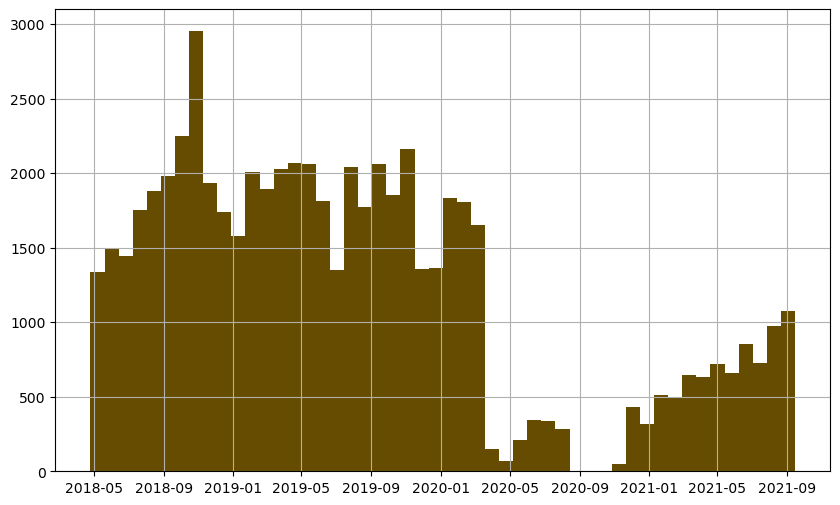

In [98]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

data_with_NA['doneChargingTime'].hist(bins=50, ax=ax, density=False, color='red')

data_unique['doneChargingTime'].hist(bins=50, ax=ax, density=False, color='green', alpha=0.6)


By comparing the histograms of the 'doneChargingTime' column before and after removing the null values, it is clear that the data distribution stays consistent. The overlapping histograms show that there is no major change in the distribution pattern after null values were removed.

#### Outlier Detection

This analysis focuses on detecting outliers in the kWhDelivered column. We start by examining the statistical summary to understand the data distribution.

In [99]:
data_unique.describe()[['kWhDelivered']]

,kWhDelivered
count,60950.000000
mean,11.583268
min,0.501000
25%,5.013000
50%,8.991000
75%,13.984000
max,108.797242
std,10.153601


Although the mean is relatively sensitive to outliers, the mean of kWhDelivered is 11.58 while the maximum is 108.8. This shows that the maximum is an outlier. We make use of a boxplot to get a visual representation.

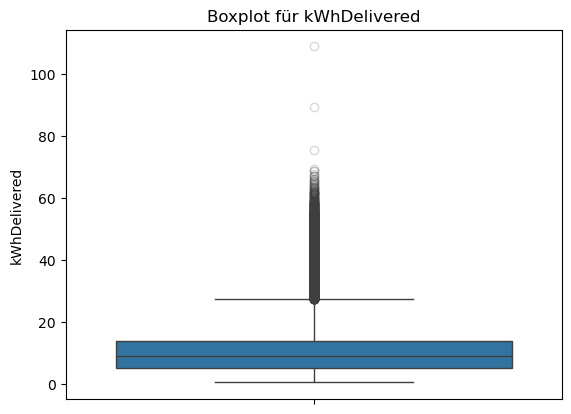

In [100]:
plt.figure()
sns.boxplot(data=data_unique, y='kWhDelivered', flierprops={'alpha': 0.2})

plt.title('Boxplot für kWhDelivered')
plt.ylabel('kWhDelivered')
plt.show()

The following function calculates the IQR to detect outliers.

In [101]:
def find_outliers_IQR(df):

   q1=df.quantile(0.25)

   q3=df.quantile(0.75)

   IQR=q3-q1

   outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]

   return outliers

In [102]:
outliers = find_outliers_IQR(data_unique['kWhDelivered'])

print("number of outliers: "+ str(len(outliers)))

print("max outlier value: "+ str(outliers.max()))

print("min outlier value: "+ str(outliers.min()))

outliers

number of outliers: 5168
max outlier value: 108.79724166666666
min outlier value: 27.442


1        33.097
6        43.477
7        32.441
13       39.806
21       49.874
          ...  
65003    32.334
65005    30.030
65008    35.007
65024    30.198
65029    41.047
Name: kWhDelivered, Length: 5168, dtype: float64

#### Extracting "userInputs" into a Separate Table

Process the column userInputs to ensure each entry is JSON-formatted and interpretable as a Python dictionary.

In [103]:
import json

data_unique['userInputs'] = data_unique['userInputs'].astype("string")

def format_user_input(entry):
    try:
        entry = entry[2:-2]
        entry = entry.replace("'", "\"").replace("True", "true").replace("False", "false")  
        return json.loads(entry)  
    except json.JSONDecodeError:
        return None  


data_unique['userInputs']= data_unique['userInputs'].apply(format_user_input)

This code extracts the contents of the userInputs column into a separate table for better clarity and organization of data. By splitting out userInputs, each nested entry can be analyzed individually, providing a more detailed view of the information stored within. This approach makes it easier to work with and understand the data structure, especially when userInputs contains multiple key-value pairs or complex JSON objects. By creating a dedicated table, each entry can be accessed, processed, and filtered independently, enhancing data readability and simplifying further analysis.

In [104]:
# Split nested lists in 'userInputs' into separate rows, resetting index for a clean DataFrame.
data_unique_splitted = data_unique.explode('userInputs', ignore_index=True)

# Select only specific columns 'id', 'userID', and 'userInputs' from the exploded DataFrame.
userInputs_data = data_unique_splitted[['id', 'userID', 'userInputs']]

# Rename the 'id' column to 'data_unique_id' for clarity.
userInputs_data = userInputs_data.rename(columns={'id': 'data_unique_id'})

# Add a new column 'id' with a unique sequential identifier for each row.
userInputs_data['id'] = range(1, len(userInputs_data) + 1)

# Expand the JSON data in 'userInputs' column to separate columns for each key-value pair.
userInputs_expanded = pd.json_normalize(userInputs_data['userInputs'])

# Concatenate the expanded data with the original DataFrame along columns (side by side).
userInputs_data = pd.concat([userInputs_data, userInputs_expanded], axis=1)

# Drop the original 'userInputs' column as it's no longer needed after expanding.
userInputs_data = userInputs_data.drop('userInputs', axis=1)

# Remove rows with missing values in critical columns 'userID', 'WhPerMile', and 'kWhRequested'.
userInputs_data = userInputs_data.dropna(subset=['userID', 'WhPerMile', 'kWhRequested'])

# Convert 'paymentRequired' column to a boolean type for correct data interpretation.
userInputs_data['paymentRequired'] = userInputs_data['paymentRequired'].astype(bool)

# Modify 'modifiedAt' column: extract only the date and time, convert to datetime in UTC, and localize to LA time.
userInputs_data['modifiedAt'] = userInputs_data['modifiedAt'].apply(
    lambda x: x.split(", ")[1].replace(" GMT", "") if isinstance(x, str) else x
)
userInputs_data['modifiedAt'] = pd.to_datetime(userInputs_data['modifiedAt'], format="%d %b %Y %H:%M:%S", utc=True, errors='coerce')
userInputs_data['modifiedAt'] = userInputs_data['modifiedAt'].dt.tz_convert('America/Los_Angeles').dt.tz_localize(None)

# Modify 'requestedDeparture' column: extract only the date and time, convert to datetime in UTC, and localize to LA time.
userInputs_data['requestedDeparture'] = userInputs_data['requestedDeparture'].apply(
    lambda x: x.split(", ")[1].replace(" GMT", "") if isinstance(x, str) else x
)
userInputs_data['requestedDeparture'] = pd.to_datetime(userInputs_data['requestedDeparture'], format="%d %b %Y %H:%M:%S", utc=True, errors='coerce')
userInputs_data['requestedDeparture'] = userInputs_data['requestedDeparture'].dt.tz_convert('America/Los_Angeles').dt.tz_localize(None)

#  drop userInputs in data_unique table since its not needed anymore
data_unique = data_unique.drop('userInputs', axis=1)


In [105]:
# split the dataset in two different. One for the station with siteID 1 and one for the station with the siteID 2 for further analysis
data_1 = data_unique[data_unique['siteID']==1]
data_2 = data_unique[data_unique['siteID']==2]

#### Preprocessing Weather Burbank Dataset

The weather dataset is also imported and duplicates are removed. Although there are none, we have carried out this step to be on the safe side.  
The data was converted to the corresponding data types and the time was adjusted to the los-angeles time zone again.  
There is some missing data in this data set for the `temperature` and the `cloud_cover`. However, these are difficult to reproduce and are therefore deleted from the data set.

In [106]:
weather_raw=pd.read_csv("data/weather_burbank_airport.csv")

# delete duplicates
columns = [
    'city', 'timestamp', 'temperature', 'cloud_cover',
    'cloud_cover_description', 'pressure', 'windspeed', 'precipitation', 'felt_temperature'
]
weather_unique = weather_raw.drop_duplicates(subset=columns)

#Transform to correct Data Types
weather_unique['city']=weather_raw['city'].astype('string')
weather_unique['timestamp'] = pd.to_datetime(weather_raw['timestamp'], utc=True).dt.tz_convert('America/Los_Angeles').dt.tz_localize(None)
weather_unique['cloud_cover_description']=weather_raw['cloud_cover_description'].astype('string')

# drop with missing values
weather_unique = weather_unique.dropna(subset=['temperature'])
weather_unique = weather_unique.dropna(subset=['cloud_cover'])

print(weather_unique.dtypes)

city                       string[python]
timestamp                  datetime64[ns]
temperature                       float64
cloud_cover                       float64
cloud_cover_description    string[python]
pressure                          float64
windspeed                         float64
precipitation                     float64
felt_temperature                  float64
dtype: object


-------------------------------------------------------------------------------------------------------------------

### Identifying the Public Charging Hub

In this section, we aim to determine which of the two sites is the public charging hub. By analyzing the provided data and combining insights from previous descriptive analytics with domain knowledge of how private company parking (reserved for employees) and public university charging stations typically operate, we will evaluate key characteristics to distinguish between the two sites.

We have a look at different criteria to make our decision:
- Time distribution: Usage paterns by time of day and weekday
- Session duration
- User diversity

-------------------------------------------------------------------------------------------------------------------

First we take a closer look at the stations. We want to know exactly how many charging stations are in the garages. 

In [107]:
def count_stations_per_site(df):
    """
    Count the number of unique stations per site.

    Parameters:
        df (pd.DataFrame): Input DataFrame containing 'stationID' and 'siteID' columns.

    Returns:
        pd.Series: Number of unique stations per site.
    """
    if 'stationID' not in df.columns or 'siteID' not in df.columns:
        raise ValueError("The provided DataFrame must contain 'stationID' and 'siteID' columns.")
    
    return df.groupby('siteID')['stationID'].nunique()

# Count unique stations for each site
station_counts = count_stations_per_site(data_unique)
print("Number of unique stations per site:")
print(station_counts)

Number of unique stations per site:
siteID
1    52
2    54
Name: stationID, dtype: int64


#### Analysis of Usage Patterns by Time of Day and Weekday

The goal of this step is to understand how the usage of the charging sites varies at different times of the day and across weekdays. By analyzing these patterns, we can gain insights into whether the site is more likely to be public (university) or private (company parking for employees).

We extract the hour of the day and the weekday from the connectionTime column in the dataset. This allows us to examine how usage varies throughout the day and the week. The hour is extracted using .dt.hour, while the weekday is derived using .dt.day_name(). These new columns enable us to visualize the usage patterns based on time of day and weekday, providing further insight into the site type.

In [108]:
data_1['hour'] = data_1['connectionTime'].dt.hour
data_1['weekday'] = data_1['connectionTime'].dt.day_name()

data_2['hour'] = data_2['connectionTime'].dt.hour
data_2['weekday'] = data_2['connectionTime'].dt.day_name()

C:\Users\carlo\AppData\Local\Temp\ipykernel_39252\3436024482.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_1['hour'] = data_1['connectionTime'].dt.hour
C:\Users\carlo\AppData\Local\Temp\ipykernel_39252\3436024482.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_1['weekday'] = data_1['connectionTime'].dt.day_name()
C:\Users\carlo\AppData\Local\Temp\ipykernel_39252\3436024482.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

This histogram visualizes the number of charging events for each hour of the day. The x-axis represents the hours (0 to 23), and the y-axis shows the total number of charging events that occurred during each hour. This visualization helps us identify peak usage times throughout the day, which can provide insights into typical charging patterns.

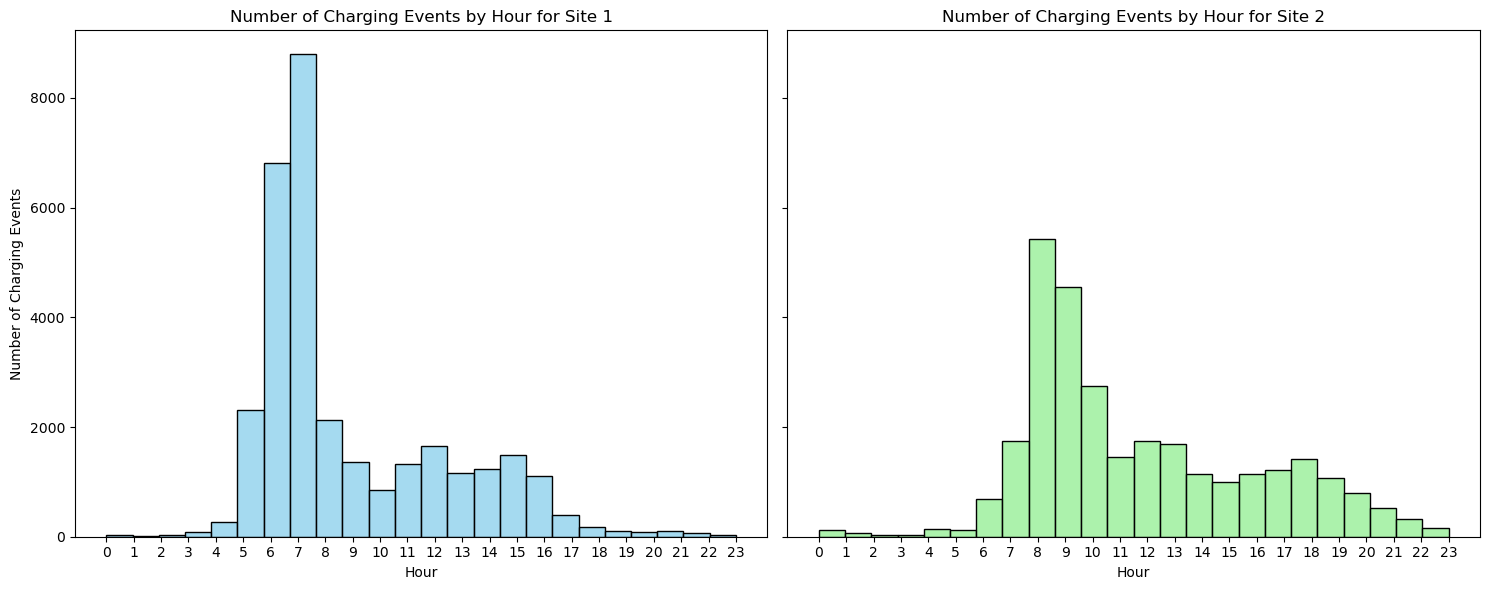

In [109]:
fig, axes = plt.subplots(1,2, figsize=(15,6), sharey=True)

sns.histplot(data=data_1, x='hour', bins=24, color="skyblue", ax=axes[0])

# Histogram of charging events per hour with full hours on the X-axis
#site 1
axes[0].set_title('Number of Charging Events by Hour for Site 1')
axes[0].set_xlabel('Hour')
axes[0].set_ylabel('Number of Charging Events')
axes[0].set_xticks(ticks=range(0, 24), labels=[f"{hour}" for hour in range(24)])  


sns.histplot(data=data_2, x='hour', bins=24, color="lightgreen", ax=axes[1])

axes[1].set_title('Number of Charging Events by Hour for Site 2')
axes[1].set_xlabel('Hour')
axes[1].set_ylabel('Number of Charging Events')
axes[1].set_xticks(ticks=range(0, 24), labels=[f"{hour}" for hour in range(24)])  

plt.tight_layout()
plt.show()

This bar chart shows the number of charging events for each day of the week. It helps us understand how usage varies across weekdays and weekends.

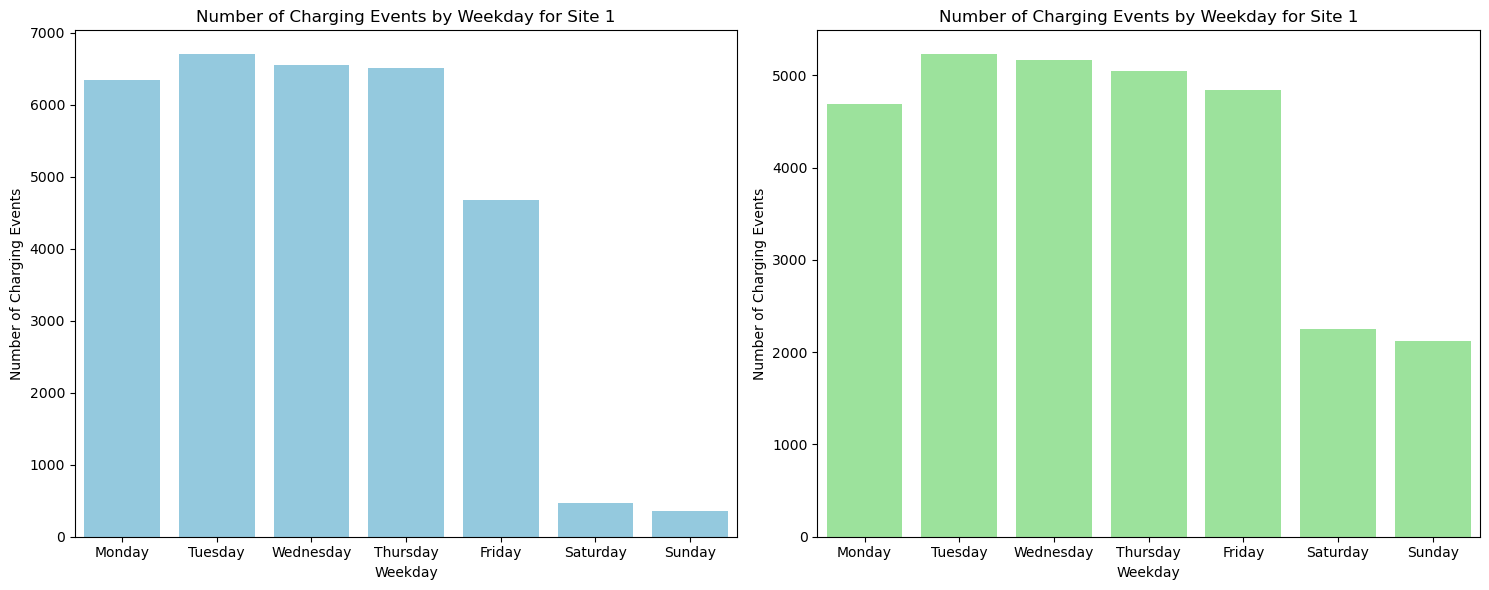

In [110]:
# Bar chart of charging events per weekday

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.countplot(data=data_1, x='weekday', order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], color="skyblue", ax=axes[0])
axes[0].set_title('Number of Charging Events by Weekday for Site 1')
axes[0].set_xlabel('Weekday')
axes[0].set_ylabel('Number of Charging Events')

sns.countplot(data=data_2, x='weekday', order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], color="lightgreen", ax=axes[1])
axes[1].set_title('Number of Charging Events by Weekday for Site 1')
axes[1].set_xlabel('Weekday')
axes[1].set_ylabel('Number of Charging Events')

plt.tight_layout()
plt.show()

-------------------------------------------------------------------------------------------------------------------

### Analysis of Charging Events by Hour and Weekday 

Charging Events per Hour:

For Site 1, the charging events primarily occur from around 5:00 AM to 5:00 PM, with a significant decline in usage afterward. This pattern suggests that the site is most heavily used during business hours, which is often characteristic of sites serving a more specific user group, such as employees of a company.

In contrast, for Site 2, the charging events occur throughout a longer period, from approximately 6:00 AM to 11:00 PM. This extended period of usage may indicate that the site is open to a broader range of users, with charging events spanning both daytime and evening hours, which is a typical feature of public charging hubs.

Charging Events per Weekday:

The second diagram presents the number of charging events per weekday. This helps us understand how usage varies between weekdays and weekends.

Both sites exhibit a general trend of higher usage on weekdays compared to weekends. However, there is a noticeable difference between the two sites. Site 2 shows more usage on weekends compared to Site 1, which aligns with the typical usage pattern for public charging stations. Public sites, like the one near the university, often experience higher demand on weekends, not only from students attending events or studying but also from other visitors who may need to use the public parking garage. In contrast, private sites, such as the company parking garage in Site 1, see much lower usage on weekends, as they are mainly used by employees during the working week.

&#8594;
These insights strongly suggest that Site 2 is the public charging station, likely located at the university, while Site 1 is the private company parking garage, as the usage pattern matches the expected behavior for these types of locations.

-------------------------------------------------------------------------------------------------------------------

#### User Count and Diversity

In this step, we aim to determine whether the site is primarily used by repeat users or a diverse range of users. A public site is expected to have a higher number of unique users, as it serves a broader, more varied group. In contrast, a private site, like a company parking garage, might show repeated usage by the same set of users, as it is typically restricted to employees or specific individuals.

In this code, we are counting the unique user IDs (userID) for Site 1 and checking how many missing values exist in the userID column.

In [111]:
# Count the unique userIDs for siteID 1
unique_users_per_site_1 = data_1['userID'].nunique()

# Display the result for verification
print(f"Number of unique (distinct) userIDs for Site 1: {unique_users_per_site_1}")

# Count the missing values in the 'userID' column
missing_values_userID_1 = data_1['userID'].isnull().sum()

# Output the number of missing values
print(f"Number of missing values in 'userID' for Site 1: {missing_values_userID_1}")


Number of unique (distinct) userIDs for Site 1: 511
Number of missing values in 'userID' for Site 1: 1433


In this code, we are counting the unique user IDs (userID) for Site 2 and checking how many missing values exist in the userID column for this site.

In [112]:
# Count the unique userIDs for siteID 2
unique_users_per_site_2 = data_2['userID'].nunique()

# Display the result for verification
print(f"Number of unique (distinct) userIDs for SIte 2: {unique_users_per_site_2}")

# Count the missing values in the 'userID' column
missing_values_userID_2 = data_2['userID'].isnull().sum()

# Output the number of missing values
print(f"Number of missing values in 'userID' for Site 2: {missing_values_userID_2}")

Number of unique (distinct) userIDs for SIte 2: 459
Number of missing values in 'userID' for Site 2: 14873


Now we create a comparison DataFrame to visualize the number of unique users for Site 1 and Site 2, and generate a bar chart to display the comparison between the two sites.

In [113]:
#compare number of unique user IDs per side
comparison_unique_users = pd.DataFrame({
    'siteID': ['site1', 'site2'],
    'unique_users': [unique_users_per_site_1, unique_users_per_site_2]
})

In [114]:
#compare number of missing user IDs per site
comparison_missing_users = pd.DataFrame({
    'siteID': ['site1', 'site2'],
    'unique_users': [missing_values_userID_1, missing_values_userID_2]
})

C:\Users\carlo\AppData\Local\Temp\ipykernel_39252\1173510978.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='siteID', y='unique_users', data=comparison_unique_users, palette=custom_palette, ax=axes[0])
C:\Users\carlo\AppData\Local\Temp\ipykernel_39252\1173510978.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='siteID', y='unique_users', data=comparison_missing_users, palette=custom_palette, ax=axes[1])


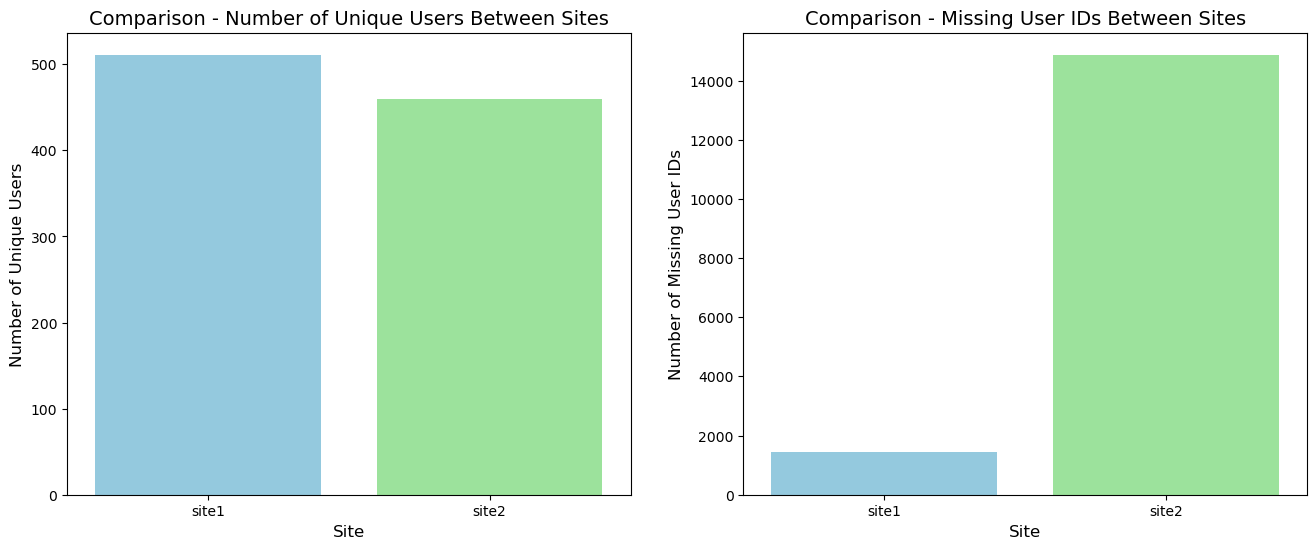

In [115]:
custom_palette = {'site1': 'skyblue', 'site2': 'lightgreen'}


fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot for the number of unique users per site
sns.barplot(x='siteID', y='unique_users', data=comparison_unique_users, palette=custom_palette, ax=axes[0])
axes[0].set_title('Comparison - Number of Unique Users Between Sites', fontsize=14)
axes[0].set_xlabel('Site', fontsize=12)
axes[0].set_ylabel('Number of Unique Users', fontsize=12)

# Plot for the number of missing user IDs per site
sns.barplot(x='siteID', y='unique_users', data=comparison_missing_users, palette=custom_palette, ax=axes[1])
axes[1].set_title('Comparison - Missing User IDs Between Sites', fontsize=14)
axes[1].set_xlabel('Site', fontsize=12)
axes[1].set_ylabel('Number of Missing User IDs', fontsize=12)



# Display the plots
plt.show()

### Analysis of User Count and Diversity

The diagrams reveal several insights about the two sites, Site 1 and Site 2.

Unique Users: Both sites show a similar number of unique users, with values in the same range for both locations. This indicates that, in terms of unique user activity, both sites are relatively comparable.

Missing User IDs: However, the second diagram reveals a significant difference in the number of missing userID values. Site 2 has 14,873 missing values compared to only 1,433 for Site 1. 

Conclusion: The high number of missing user IDs at Site 2 suggests it is the public charging hub, likely at the university, where there is a mix of registered and non-registered users. In contrast, Site 1, with fewer missing IDs, is more consistent with a private site, such as a company parking garage, where the usage is mainly from registered employees.

-------------------------------------------------------------------------------------------------------------------

### Charging Duration and Energy Consumption

Objective: The goal of this analysis is to determine if charging durations and energy consumption patterns indicate a specific type of location.

This section calculates the charging duration for both datasets. The charging duration is derived by subtracting the connectionTime from the disconnectTime and then converting the result from seconds to hours.

In [116]:
# Calculate the charging duration in hours for both datasets
data_1['chargingDuration'] = (data_1['disconnectTime'] - data_1['connectionTime']).dt.total_seconds() / 3600
data_2['chargingDuration'] = (data_2['disconnectTime'] - data_2['connectionTime']).dt.total_seconds() / 3600

C:\Users\carlo\AppData\Local\Temp\ipykernel_39252\3744816354.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_1['chargingDuration'] = (data_1['disconnectTime'] - data_1['connectionTime']).dt.total_seconds() / 3600
C:\Users\carlo\AppData\Local\Temp\ipykernel_39252\3744816354.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2['chargingDuration'] = (data_2['disconnectTime'] - data_2['connectionTime']).dt.total_seconds() / 3600


In this step, summary statistics (mean and median) for the charging duration and kWh delivered are calculated for both sites (siteID=1 and siteID=2).

In [117]:
# Summary for siteID=1
summary_stats_1 = data_1[['chargingDuration', 'kWhDelivered']].agg(['mean', 'median']).reset_index()
summary_stats_1['siteID'] = 1

# Summary for siteID=2
summary_stats_2 = data_2[['chargingDuration', 'kWhDelivered']].agg(['mean', 'median']).reset_index()
summary_stats_2['siteID'] = 2

# Combine the statistics for both sites
summary_stats = pd.concat([summary_stats_1, summary_stats_2])
print("Summary of Charging Duration and Energy Consumption:")
print(summary_stats)


Summary of Charging Duration and Energy Consumption:
    index  chargingDuration  kWhDelivered  siteID
0    mean          6.871289     14.163597       1
1  median          7.601806     11.290000       1
0    mean          5.846978      8.806589       2
1  median          4.988333      6.588000       2


 The goal of these visualizations is to compare the charging duration and energy consumption for the two sites (siteID=1 and siteID=2). The first two plots are boxplots that show the distribution of charging duration and energy delivered for each site, while the last two plots are histograms that provide further insight into the distribution of charging durations and energy consumption.

C:\Users\carlo\AppData\Local\Temp\ipykernel_39252\1634907971.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=pd.concat([data_1.assign(siteID=1), data_2.assign(siteID=2)]), x='siteID', y='chargingDuration', palette='pastel')


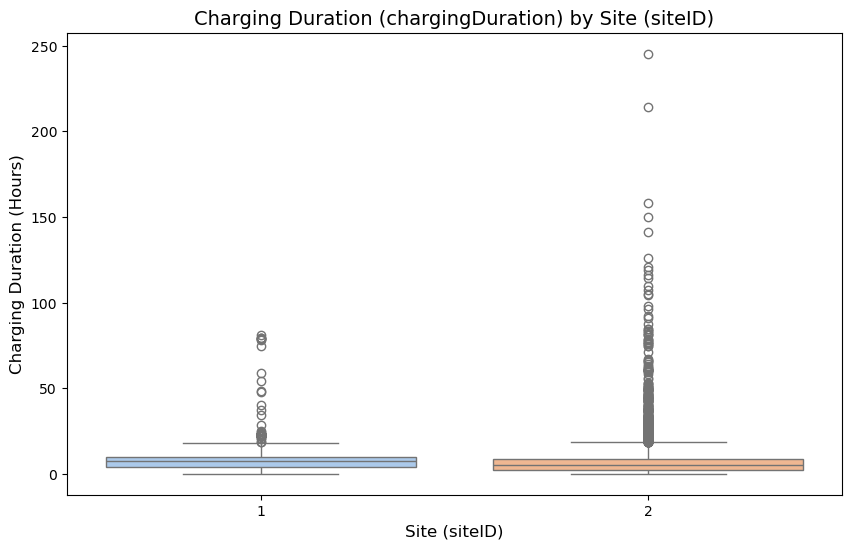

C:\Users\carlo\AppData\Local\Temp\ipykernel_39252\1634907971.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=pd.concat([data_1.assign(siteID=1), data_2.assign(siteID=2)]), x='siteID', y='kWhDelivered', palette='muted')


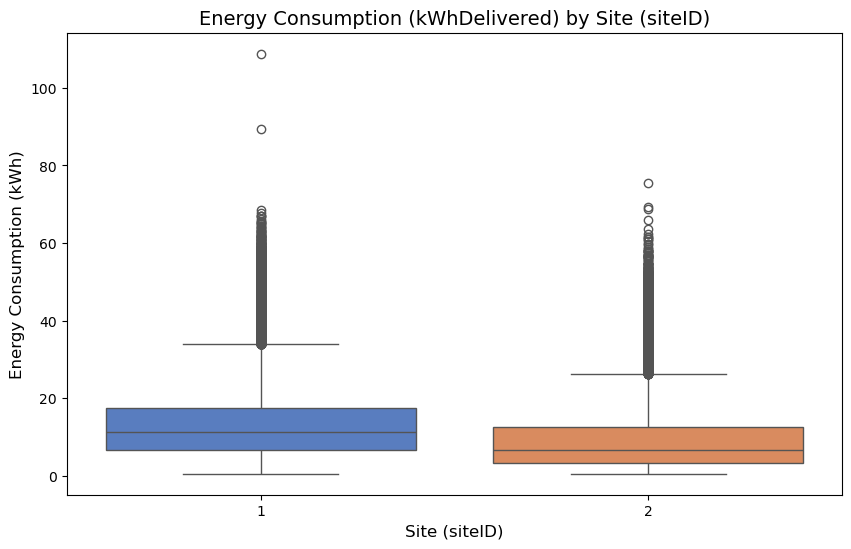

In [118]:
# Boxplot for charging duration by site
plt.figure(figsize=(10, 6))

# Boxplots for both datasets
sns.boxplot(data=pd.concat([data_1.assign(siteID=1), data_2.assign(siteID=2)]), x='siteID', y='chargingDuration', palette='pastel')

plt.title("Charging Duration (chargingDuration) by Site (siteID)", fontsize=14)
plt.xlabel("Site (siteID)", fontsize=12)
plt.ylabel("Charging Duration (Hours)", fontsize=12)
plt.show()

# Boxplot for energy consumption by site
plt.figure(figsize=(10, 6))

# Boxplots for both datasets
sns.boxplot(data=pd.concat([data_1.assign(siteID=1), data_2.assign(siteID=2)]), x='siteID', y='kWhDelivered', palette='muted')

plt.title("Energy Consumption (kWhDelivered) by Site (siteID)", fontsize=14)
plt.xlabel("Site (siteID)", fontsize=12)
plt.ylabel("Energy Consumption (kWh)", fontsize=12)
plt.show()



#### Analysis of Charging Duration and Energy Consumption

Summary of Key Statistics:

Site 1 (University / Public):

Average charging duration: 6.87 hours

Median charging duration: 7.60 hours

Average energy consumption: 14.16 kWh

Median energy consumption: 11.29 kWh


Site 2 (Company / Private):

Average charging duration: 5.85 hours

Median charging duration: 4.99 hours

Average energy consumption: 8.81 kWh

Median energy consumption: 6.59 kWh

Boxplots:

The boxplot for charging duration reveals that the distribution of charging times at Site 1 is slightly higher and broader than at Site 2. This suggests that vehicles tend to stay connected for longer periods at Site 1, aligning with predictable usage patterns by employees.

The boxplot for energy consumption indicates that both the average and median energy consumption at Site 1 are higher than at Site 2. This could be attributed to longer charging durations and a controlled environment with regular users.

Conclusion

Longer Charging Durations and Higher Energy Consumption at Site 1:

The longer charging durations and higher energy consumption at Site 1 support the assumption that this location is the private company parking lot. Employees typically have fixed working hours, allowing for longer charging times as vehicles remain plugged in throughout the workday.

Shorter Charging Durations and Lower Energy Consumption at Site 2:

At Site 2, shorter charging durations and lower energy consumption indicate a more public usage pattern. This aligns with the idea that Site 2 is the public location near the university, where vehicles are parked for shorter periods and charging sessions are less consistent.